## The model

We are dealing with the following system of Stochastic Delay Differential Equations:
$$dX_i(t)=(-X_i(t)+ \frac{1}{N} \sum_{j=1}^N w_{ij}  X_j(t-\tau_{ij}))dt+\sqrt{2D}dW_i(t),$$

with history (initial conditions): $$X_i(t)=X_0 , \ t  \ in \ [- \tau_{N}, 0], \ i=1...N $$

This network is a reasonable model (given some assumptions) for neural interactions across white matter, where conduction velocity is finite.

We are looking for a way to determine the variance of the mean activity as a function of the systems parameters, especially the variance of the delay distribution. 



## The relationship between the variance of the mean activity and the variance of the distrubution delays 

The paper "Kramers-Moyal expansion for stochastic differential equations with single and multiple delays : Applications to financial physics and neurophysics", T. D. Frank, DOI:10.1016/J.PHYSLETA.2006.08.062Corpus, suggests a way for computing the variance for a Stochastic Delay Differential Equation.

We try to expand numerically these results for a system of coupled SDDEs. Below some corrections and numerical results:


$$ variance  = \frac{2D}{2N \gamma} $$

with

$$\gamma = 1-\frac{1}{N^2} \sum_{{i,j}=1}^N w_{ij}e^{ - \tau_{ij}} \sim 1- \overline w \ \frac{1}{N^2} \sum_{{i,j}=1}^N e^{ - \tau_{ij}} $$ 

in the limit $N \rightarrow \infty$ :

$$ \lim_{N \to \infty } \gamma =  1 - \overline w \ \int_{0}^{\infty} p(\tau) e^{-\tau} \, d\tau =  1 - \overline w \ G(\alpha, \beta)$$

where $p(\tau):=p(\tau, \alpha, \beta)$ and

$$   G(\alpha, \beta) = \int_{0}^{\infty} p(\tau) e^{-\tau} \, d\tau  $$ is the Laplace transform of the delays distribution $\mathcal{L}(p(\tau)) = L(s=1)$, that is something known and depends on the delays distribution parameters $\alpha$ and $\beta$.


Let's understand what is the relationship between the variance of the mean process and the variance of the distribution of the delays:
$$var(\tau) \  \rightarrow  \ ? \ var(<x>) $$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
from scipy import stats
from scipy.stats import randint, poisson
from scipy.stats import norm

In [2]:
# define model parameters
t_0 = 0 
t_end = 10000
length = 100000
sigma = 0.2                           #sigma=sqrt(2D), wuth D diffusion coefficient

t = np.linspace(t_0,t_end,length)     #define time
dt = np.mean(np.diff(t))              #define step size 0.1

In [3]:
#define the formula for the variance (as in TD Frank paper)

def var(T,gamma, N):                                     
    
    var=((sigma**2)/(2*(gamma)))

    var=var/N                                                
    
    return(var)

The Gamma distribution is $p(\tau)= \frac{\beta^\alpha}{\Gamma(\alpha)} \tau^{\alpha-1} e^{\beta \tau}$, and its Laplace transform is

$$   \mathcal{L}(p(\tau)) = \int_{0}^{\infty} p(\tau) e^{- s \tau} \, d\tau = \frac{\beta^\alpha}{(\beta + s)^\alpha} $$ 

> we are interested in the specific case s=1, so $L(s=1)=\frac{\beta^\alpha}{(\beta + 1)^\alpha}$

In [4]:
#define the new gamma 

def gamma_L(w_,mu,var): 
    
    a_=(mu**2)/var
    b_=mu/var
    
    laplace_distri1=(b_/(b_+1))**a_
    
    g=1-np.mean(w_)*laplace_distri1 
    
    return(g)

Let's solve the system, with the Euler method (remark: the system is not Markovian...the Euler method has to be properly adjusted)

In [18]:
def model_cn(N, variance, mu):
    
    k,teta = (mu**2)/variance, variance/mu                      #set variance and mean of the delays distribution
    
    
    
    np.random.seed(0)
    W = np.random.uniform(-0.2,0,(N,N))                         #set small weights
 
    np.random.seed(0)
    d = (np.random.gamma(k,teta, size=(N,N))).astype(int)       #gamma(shape, scale)=gamma(k,teta)=gamma(alpha,1/beta)

    X = np.ones((N, length))    

    XD = np.zeros((length,N,N))

    ################### 

    DRIFT = lambda X, XD, N, W, t: -X+(1/N)*sum(W*XD)    

    diffusion = lambda x, t: sigma*np.ones(N).T               

    np.random.seed(0)
    noise = np.random.normal(loc=0.0,scale=1.0,size=(N,length))*np.sqrt(dt)        #white noise

    ###################
    
    for k in range(length-1):       
        
        M=np.fromfunction(lambda i, j: X[j,k-d[i,j]], (N, N), dtype=int)
        
        X[:,k+1] = X[:,k] + DRIFT(X[:,k], M, N, W, k*dt)*dt + diffusion(X[:,k], k*dt)*noise[:,k+1]           
        
    m=sum(X)/N                    #mean activity
    v=np.std(m)**2                #variance of the mean activity
    
    gammaM=gamma_L(W,mu,variance)
    
    v2=var(t_end, gammaM, N)      #paper variance (correction of the formula on the paper)
        
    error=100*abs((v-v2)/v)       #relative error between computed and real variance of the process
         
    return(error, v, v2, np.std(d)**2, m)

## Numerical results
Implementation of the moel for different parameters - iteration over the variance of the variance of the delays.
- for each iteration print: the true variance, the computed variance (formula), the absolute relative error between the two
- plot: the variance of the mean activity as function of the variance of the delays

#### 10 neurons

In [19]:
from tqdm.notebook import tqdm 

In [20]:
vari=[]
vartd=[]
vartau=[]
M=[]
E=[]
for i in tqdm(range(1,100)):
    er, v, vtd, vtau, m = model_cn(10,i,5)  #iterate over variance, mean fixed=5
    print(i,v,vtd,er)
    vari.append(v)
    vartd.append(vtd)
    vartau.append(vtau)
    M.append(m)
    E.append(er)

1 0.0020375906109157127 0.0019977918449911266 1.953226801859876
2 0.002036853167229371 0.0019968612414147926 1.9634172191693766
3 0.0020371159816445794 0.001995810810683063 2.0276298126221755
4 0.0020360419899323095 0.0019946614108315563 2.0324030302601432
5 0.0020350384435266983 0.0019934315662360636 2.044525371153699
6 0.0020348968069018865 0.001992137356560601 2.101308046494323
7 0.0020349061688019355 0.001990792553841837 2.1678451633998823
8 0.0020338978688371496 0.0019894088576079567 2.187376854602283
9 0.0020334681318479567 0.0019879961552581784 2.2361784715285737
10 0.0020329760041507623 0.0019865627737944104 2.2830190942534134
11 0.0020318635257911967 0.0019851157085438026 2.3007360806474804
12 0.002030979143246605 0.001983660824233244 2.3298279143192353
13 0.0020302583131709905 0.0019822030284603375 2.36695421458943
14 0.0020303065399453375 0.001980746419701206 2.4410166282312207
15 0.0020304168747358096 0.0019792944127745103 2.517830825650086
16 0.0020297156464953595 0.001977

In [21]:
print('the mean error is:',np.mean(E))

the mean error is: 3.682228514867336


Text(0.5, 1.0, 'numerical variance of the process')

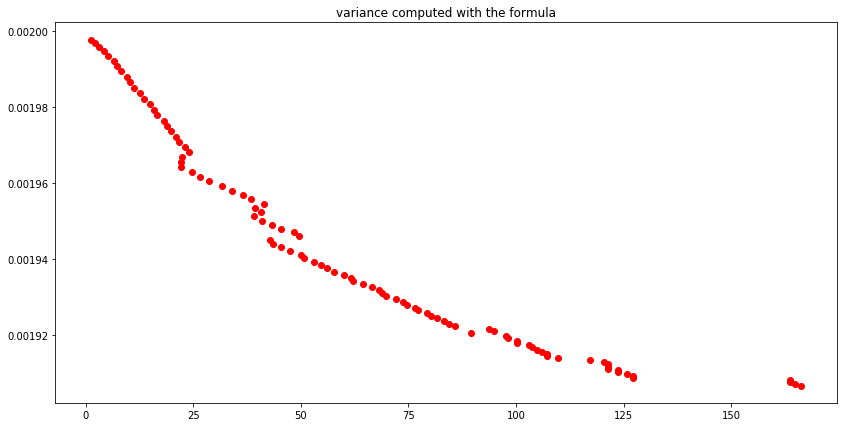

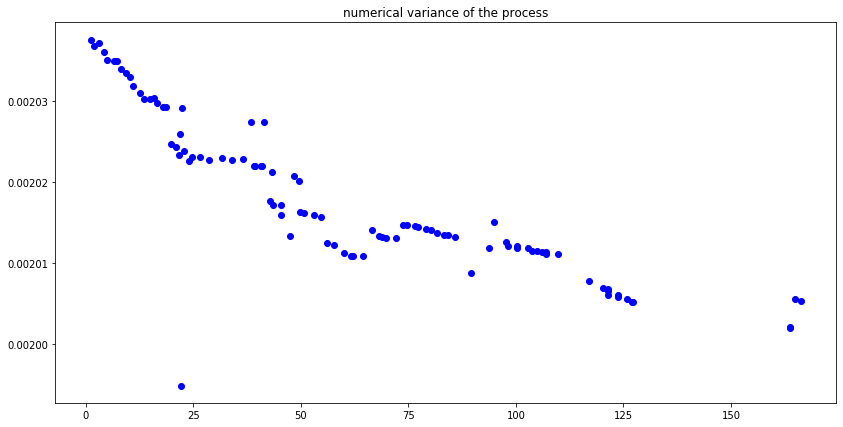

In [26]:
#display the results
vartau=np.array(vartau)
vartd=np.array(vartd)
vari=np.array(vari)

plt.figure(figsize=(14,7))
plt.plot(vartau, vartd, 'ro')
plt.title('variance computed with the formula')

plt.figure(figsize=(14,7))
plt.plot(vartau, vari, 'bo')
plt.title('numerical variance of the process')

Text(0.5, 1.0, 'gamma distribution of delays: variances of the mean activity as the delays variance varies')

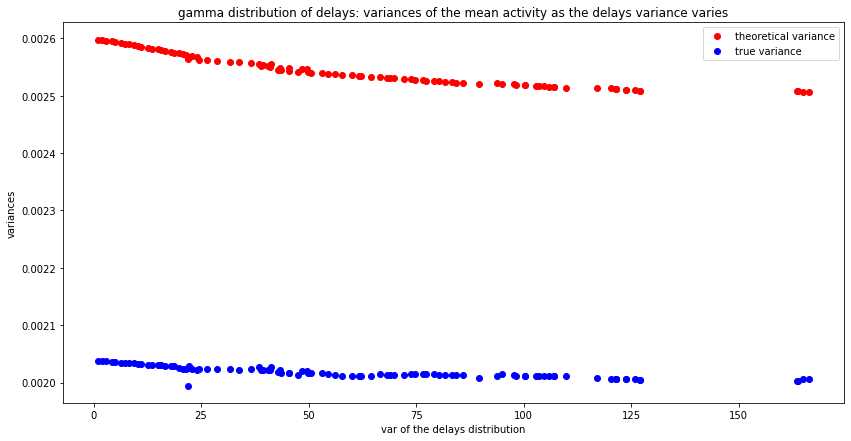

In [27]:
fig, ax = plt.subplots(1, figsize=(14,7))
ax.plot(vartau, vartd+0.0006, 'ro')
ax.plot(vartau, vari, 'bo')
ax.set_xlabel('var of the delays distribution')
ax.set_ylabel('variances')
ax.legend(['theoretical variance', 'true variance'])
ax.set_title('gamma distribution of delays: variances of the mean activity as the delays variance varies')

### 100 neurons

In [28]:
vari=[]
vartd=[]
vartau=[]
M=[]
E=[]
for i in tqdm(range(1,100)):
    er, v, vtd, vtau, m = model_cn(100,i,5)  #iterate over variance, mean=5
    print(i,v,vtd,er)
    vari.append(v)
    vartd.append(vtd)
    vartau.append(vtau)
    M.append(m)
    E.append(er)

1 0.0002475084108498187 0.000199789085937966 19.279880125288948
2 0.0002474593115097081 0.00019970019217483605 19.2997867178655
3 0.00024740453076632445 0.0001995998477369546 19.322476787832862
4 0.0002473343878482231 0.00019949004365979437 19.343991995883904
5 0.0002472682270705612 0.0001993725482878414 19.36992849835582
6 0.0002472152713308395 0.00019924889667884696 19.402674597638754
7 0.0002471724352169765 0.00019912040368868538 19.440691874119935
8 0.00024712993377249304 0.0001989881864091577 19.48033839059515
9 0.00024706609281166037 0.00019885318901381 19.514172604252614
10 0.0002470253796278506 0.0001987162067766896 19.556360129448997
11 0.0002469544303983993 0.00019857790789442887 19.589250707479504
12 0.0002469137306455265 0.0001984388526696557 19.632313621903084
13 0.000246863048799439 0.00019829951006044238 19.672259163602686
14 0.00024677535000664896 0.00019816027180031775 19.700135449112462
15 0.0002467242765957051 0.0001980214643675694 19.739773037390474
16 0.00024673501

In [31]:
print('the mean error is:',np.mean(E),'%')

the mean error is: 20.870246976579107 %


Text(0.5, 1.0, 'numerical variance of the process')

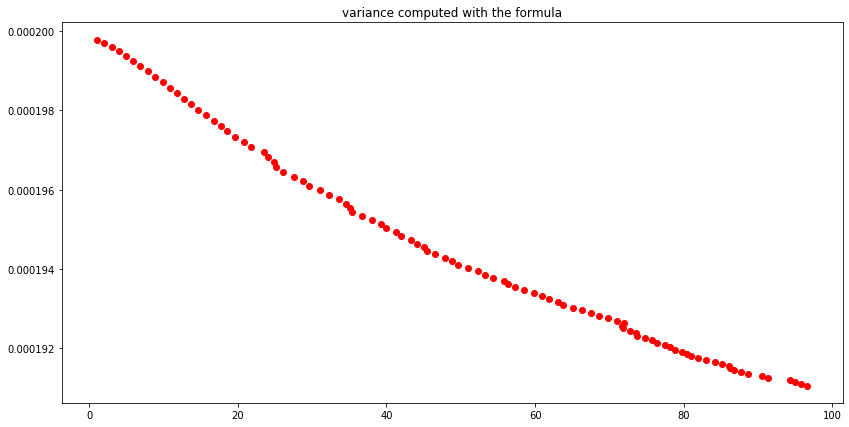

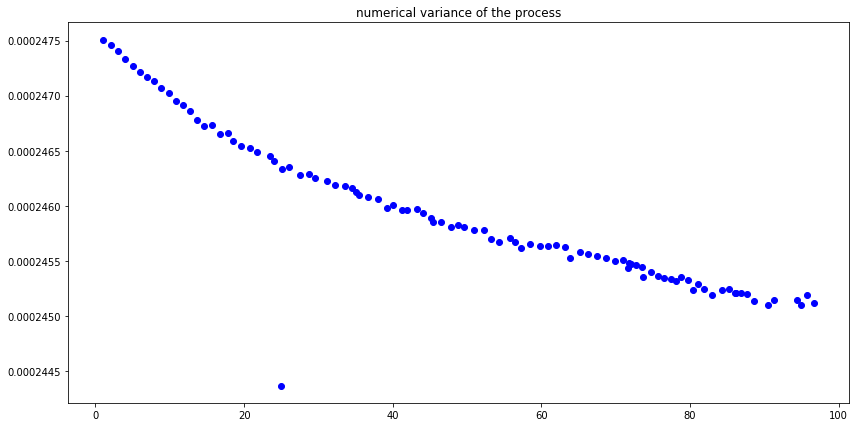

In [32]:
#display the results
vartau=np.array(vartau)
vartd=np.array(vartd)
vari=np.array(vari)

plt.figure(figsize=(14,7))
plt.plot(vartau, vartd, 'ro')
plt.title('variance computed with the formula')

plt.figure(figsize=(14,7))
plt.plot(vartau, vari, 'bo')
plt.title('numerical variance of the process')

Text(0.5, 1.0, 'gamma distribution of delays: variances of the mean activity as the delays variance varies')

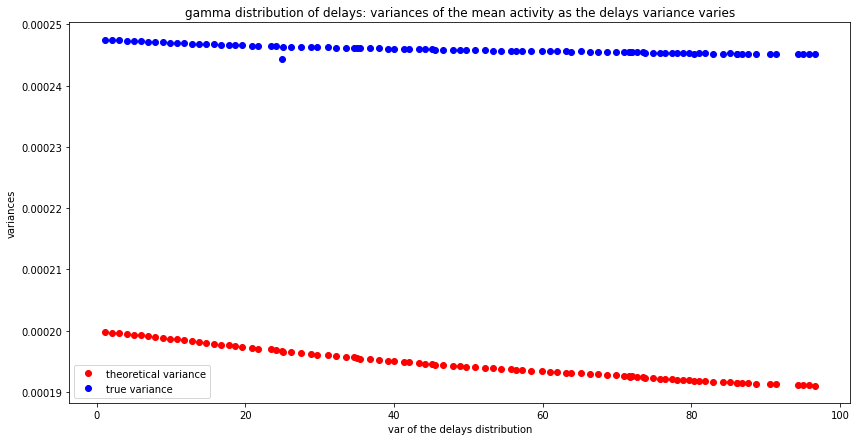

In [33]:
fig, ax = plt.subplots(1, figsize=(14,7))
ax.plot(vartau, vartd, 'ro')
ax.plot(vartau, vari, 'bo')
ax.set_xlabel('var of the delays distribution')
ax.set_ylabel('variances')
ax.legend(['theoretical variance', 'true variance'])
ax.set_title('gamma distribution of delays: variances of the mean activity as the delays variance varies')

> I am facing with the following problem: error propagation. I am currently working on it